In [1]:
import numpy as np
import csv
from lyricsgenius import Genius
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
import re
from sklearn.preprocessing import normalize
import functools
import json
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# FORMATTING TO TRANSFORM CSV FILE TO JSON
# GO TO 'TFIDF/SVD PROCESSING'

df = pd.read_csv('0-550.csv')
df2 = pd.read_csv('1074-1699.csv')

In [66]:
artists_0_550 = df['Unnamed: 0']
lyrics_0_550 = df[[str(i) for i in range(10)]].values.tolist()

artists_1074_1699 = df2['Unnamed: 0']
lyrics_1074_1699 = df2[[str(i) for i in range(10)]].values.tolist()

In [67]:
def construct_artist_lyrics_dict(artists, lyrics):
    """ Returns a dictionary mapping artist name to a list of lyrics of their
        top ten songs.
        
    Params:
        artists: list of artist names
        lyrics: corresponding list of list of lyrics
    Returns: dict
    """
    return {artists[i]: lyrics[i] for i in range(len(artists))}

In [68]:
artists_lyrics_0_550 = construct_artist_lyrics_dict(artists_0_550, lyrics_0_550)
artists_lyrics_1074_1699 = construct_artist_lyrics_dict(artists_1074_1699, lyrics_1074_1699)

In [69]:
def concatenate_lyrics(lyrics):
    """ Returns a dictionary mapping artist name to a string containing all lyrics of their
        top ten songs.
        
    Params:
        lyrics: dict mapping artist name to list of lyrics
    Returns: dict
    """
    documents = {}
    for artist in lyrics:
        all_lyrics = ""
        for song in lyrics[artist]:
            if type(song) == 'str':
                all_lyrics += song
        documents[artist] = all_lyrics
    return documents

In [70]:
artist_documents_0_550 = concatenate_lyrics(artists_lyrics_0_550)
artist_documents_1074_1699 = concatenate_lyrics(artists_lyrics_1074_1699)

artist_lyrics_dicts.extend([artist_documents_0_550, artist_documents_1074_1699])

with open('artist_lyrics_0-550.json', 'w') as outfile:
    json.dump(artist_documents_0_550, outfile)
with open('artist_lyrics_1074-1699.json', 'w') as outfile:
    json.dump(artist_documents_1074_1699, outfile)

In [2]:
# TFIDF/SVD PROCESSING
# START PREPROCESSING FOR TFIDF-MATRIX AND SVD

artist_lyrics_dicts = []
# path = '../data/processed/ignore/' 
path = ""
for filename in ['artist_lyrics_0-882.json', 'artist_lyrics_883-1764.json',
                 'artist_lyrics_1764-2645.json', 'artist_lyrics_2646-3526.json',
                 'artist_lyrics_3528-4409.json']:
    with open(path + filename) as json_file:
        artist_lyrics_dicts.append(json.load(json_file))

In [5]:
unique_artists = set([i for d in artist_lyrics_dicts for i in d])

artist_lyrics = {}
for mapping in artist_lyrics_dicts:
    artist_lyrics.update(mapping)
artist_lyrics = {i: artist_lyrics[i] for i in unique_artists}

artist_names = list(artist_lyrics)
assert len(artist_names) == len(unique_artists)
artist_name_to_index = {artist_names[i] : i for i in range(len(artist_names))}

artist_documents = [artist_lyrics[artist] for artist in artist_names]

In [6]:
def build_vectorizer(max_n_terms=5000, max_prop_docs = 0.8, min_n_docs = 10):
    """Returns a TfidfVectorizer object with certain preprocessing properties.
    
    Params: {max_n_terms: Integer,
             max_prop_docs: Float,
             min_n_docs: Integer}
    Returns: TfidfVectorizer
    """
    return TfidfVectorizer(max_df=max_prop_docs, min_df=min_n_docs, max_features=max_n_terms, stop_words='english')

In [7]:
tfidf_vec = build_vectorizer()
tfidf_mat = tfidf_vec.fit_transform(artist_documents).toarray()
vocab = tfidf_vec.get_feature_names()

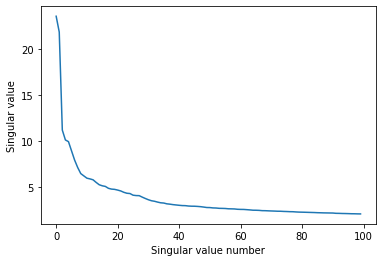

In [8]:
# Plot singular values of the k=100 terms
u, s, v_trans = svds(tfidf_mat, k=100)

plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [9]:
u, s, v = svds(tfidf_mat, k=40)
v = v.transpose()

In [10]:
print(u.shape)
print(v.shape)

(4408, 40)
(5000, 40)


In [12]:
doc_rows = normalize(u, axis=1)
word_rows = v

def closest_projects(project_index_in, k = 5):
    sims = doc_rows.dot(doc_rows[project_index_in,:])
    asort = np.argsort(-sims)[:k+1]
    return [(artist_names[i],sims[i]/sims[asort[0]]) for i in asort[1:]]

In [13]:
# for i in range(40, 50):
#     print(artist_names[i])
#     for title, score in closest_projects(i):
#         print("{}:{:.3f}".format(title[:40], score))
#     print()

index = artist_name_to_index["BTS"]
for title, score in closest_projects(index):
    print("{}:{:.3f}".format(title[:40], score))

The Summer Set:0.895
Roxette:0.882
Everclear:0.877
Kaiser Chiefs:0.863
Katrina & The Waves:0.853


In [14]:
tfidf_mat_uncompressed = pd.DataFrame(tfidf_mat, columns = vocab, index = artist_names)
tfidf_mat_compressed = pd.DataFrame(doc_rows, index = artist_names)
words_compressed = pd.DataFrame(word_rows, index = vocab)

In [15]:
tfidf_mat_compressed.to_csv('tfidf_mat_compressed.csv')
tfidf_mat_uncompressed.to_csv('tfidf_mat_uncompressed.csv')
words_compressed.to_csv('words_compressed.csv')